# IBM Coursera Applied Data Science Capstone Project ('The Battle of Neighborhoods')

# Jupyter Notebook: Rise of the small bars – are there inner Sydney suburbs that are potentially untapped?

### This notebook contains the full code for the research and analysis supporting the Report document which is available here: 

https://github.com/ew92/Coursera-Capstone/blob/master/CourseraCapstone_FinalReport.ipynb


---
## Contents

* **Setup**
  * Import libraries


* **Section 1: Project and data overview**
  * 1.1: Background and aims of the project
  * 1.2: Data
  * 1.3: Overview of methodology


* **Section 2: Analysis**
  * 2.1: Preparatory steps and IDA
    * Geocoding and examining the suburbs of interest 
    * NSW Liquor Licence Premises List (Data.NSW)
    * Domain Liveable Sydney Study data (Domain, Tract and Deloitte)
  * 2.2: Foursquare API queries and extraction (Part 1)
  * 2.3: K-means cluster analysis for suburb similarity
    * Venue data dummification and standardisation
    * Model selection
    * Running k-means algorithm, examining clusters and mapping cluster membership
  * 2.4: Liveable Sydney Study data


* **Section 3: Evaluation informing report recommendations**
  * 3.1: Evaluating the two types of opportunity suburbs
      * 'Untapped neighbours to night time economy centres'
      * 'New directions'
  * 3.2: Recommended suburbs for future small bar locations

---

### Setup

In [1]:
# Importing required libraries

import pandas as pd # for data wrangling and analysis
import geopandas as gpd # for spatial geometry aware data analysis
import numpy as np # for vectorized handling of data

import requests # for request handling
import json # for json handling
from pandas.io.json import json_normalize # for transforming json into pandas df

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors # For creation of plots
from sklearn.cluster import KMeans # For k-means cluster analysis

import geopy
from geopy.geocoders import Nominatim # for geocoding
import time # for sleeping Nominatim loop in geocode function

import folium # for mapping
from folium import plugins # for extending mapping aesthetics

from statistics import *

print('Libraries imported.')

Libraries imported.


---

## Section 1: Project and data overview

### 1.1: Background and aims of the project
**Context**

For a particular market segment of bar patrons, inner Sydney has seen an emerging preference for small bars. While traditional Australian licensed venue types remain popular – pubs/hotels/bistros, sports and RSL clubs, nightclubs – the small bar is an emerging venue of choice for people looking for an intimate, ambient setting that is either quieter or meets an aesthetically distinct niche, compared to the larger licensed venues. The New South Wales government defines a small bar licence as follows: 

'A small bar licence allows you to sell alcohol for consumption on the licensed premises, but does not allow gaming or take-away liquor. This liquor licence allows a maximum of 120 customers, over the age of 18, on the premises during authorised trading hours.' 
(https://www.service.nsw.gov.au/transaction/apply-small-bar-licence#:~:text=A%20small%20bar%20licence%20allows,premises%20during%20authorised%20trading%20hours).

The business opportunity arises particularly from the potential for conversion of unusual commercial properties into small bars. While many retailer types lose their physical presence in favour of online marketplaces, 'experience-based' venues – like small bars – remain a viable business option for the narrow lots in the commercial centres of inner Sydney suburbs.

**Business problem**

Small bars are a rising hospitality trend in Sydney's urban fringe outside the CBD, particularly in the inner west suburbs and in the areas just south of the CBD. 

There are opportunities for new small bar businesses in these suburbs but the selection of a potential location – with choices now opened up by options provided by smaller commercial lots of unusual types and special small bar licensing – is overwhelming. The report provides recommendations for the selection of small bar locations in Sydney's inner suburbs on the precipice of the CBD based on analysis of data from the Foursquare API and the Data.NSW open data portal.

**Intended audience of the report**

The scenario for the business problem is to determine the optimal locations for the establishment of new small bars in inner Sydney. The intended audience for this report includes hospitality and entertainment business owners, companies or investors looking to move, expand or establish into new locations in inner Sydney.

### 1.2: Data

This project uses a number of publicly available flat data files, as well as the Foursquare API.

* **Data.NSW** – ***Liquor Licence Premises List June 2020***
  * Available via the New South Wales state government open data portal, this is a periodically updated CSV of all of the active liquor licences in the state. The data includes many features related to issued liquor licences, but of particular interest for this project are the addresses, licence and venue types and coordinates. This allows enhancement of the venue data retrieved via Foursquare.
  * The data is © State of New South Wales (Department of Customer Service) 2020.
  * Webpage for the dataset: https://data.nsw.gov.au/data/dataset/liquor-licence-premises-list/resource/bda22b68-8e4f-4028-b725-52dc0912a626


* **Domain Group, Tract and Deloitte Access Economics** – ***Liveable Sydney Study 2019***
  * This data is from a market research study conducted by Australian property listing and services company Domain and consultants Tract and Deloitte. This geojson dataset is an analysis of 19 'liveability indicators' for all of the suburbs in Sydney – it also then uses bucket evaluation to rank all suburbs for liveability. Of particular interest for this project are the suburb scores received for indicators relating to public transport, walkability and culture. The overall ranks are also examined.
  * The data is © Domain Group, Tract and Deloitte Access Economics 2019.
  * Webpage for the dataset: https://www.domain.com.au/liveable-sydney/sydneys-most-liveable-suburbs-2019/sydneys-569-suburbs-ranked-for-liveability-2019-903130/


* **Foursquare API** – ***Places Data***
  * Via a registered free tier account for accessing the Foursquare API, this project leverages a number of queries to the Foursquare location data database for commercial and cultural venues within defined radii.
  * See: https://foursquare.com/developers


* **Australian Bureau of Statistics** / **analysed and prepared by Jeremy Epstein** – ***Australian Local Government Area to Included Postcode Mappings***
   * We know that the area of interest is the edges of the CBD so the best way to start is with the municipal administrative area that captures the Sydney CBD and surrounding suburbs. Because of overlap between multiple LGAs, suburb inclusion within an LGA's boundaries is actually not formally provided by any central data service. The services and websites mentioned here, including previous GIS joining undertaken by Jeremy Epstein that mapped postal codes to LGAs (posted on his 'greenash' blog), were used to construct a list of suburbs of interest for this project.
   * Webpage for the dataset: https://greenash.net.au/thoughts/2014/07/australian-lga-to-postcode-mappings-with-postgis-and-intersects/
   * Google sheet which was downloaded and converted to csv: https://docs.google.com/spreadsheets/d/1tHCxouhyM4edDvF60VG7nzs5QxID3ADwr3DGJh71qFg/edit#gid=900781287
     * Additionally checked against the Wikipedia page for the City of Sydney Local Government Area: https://en.wikipedia.org/wiki/City_of_Sydney
     * Postcodes from the City of Sydney-filtered greenash csv file were looked up via https://auspost.com.au/postcode to determine additional suburbs that are adjacent to the LGA (that share postcodes with LGA member suburbs) since they also fit the scope of the urban edge areas of interest.

In [2]:
## This is the file that has been generated from the City of Sydney suburbs Wikipedia page, 
## the greenash/ABS data and Australia Post postcode lookup service:

thesuburbs = pd.read_csv('https://eugeneward.com.au/study/demodata/Sydney_C_LGA_Postcodes_Suburbs.csv')
thesuburbs.head()

,Postcode,Suburb
0,2000,Barangaroo
1,2000,Dawes Point
2,2000,Haymarket
3,2000,Millers Point
4,2000,Sydney


### 1.3: Overview of methodology

Below are the questions that direct the analysis followed by their relationships with the data and methods.

* Which of these suburbs currently have the most small bars operating and can k-means cluster analysis for suburb similarity shed any insight on which suburbs might otherwise have similar sets of activities and venues but a lack of small bars?
  * Datasets used: Foursquare API data; Data.NSW licensed premises list.


* Are there suburbs which scored highly on relevant liveability indicators in the Liveable Sydney Study dataset which: have small bars operating? Do not have any small bars operating?
  * Datasets used: Domain Liveable Sydney Study 2019

  
**Determination of suburbs of interest**

Membership or partial membership within the City of Sydney Local Government Area, as defined on Wikipedia – https://en.wikipedia.org/wiki/City_of_Sydney – plus additional adjacent suburbs which share postcodes with these member suburbs (through use of ABS data and Australia Post postcode lookup service mentioned above).

**Geocoding method**

For suburbs – Nominatim from the geopy client. Returned geocoded point data is at suburb-level.

---

## Section 2: Analysis

### 2.1: Preparatory steps and IDA

**Geocoding and examining the suburbs of interest**

The free Nominatim geocoding service will return a pair of coordinates for the centre of the suburb area when given the suburb name in the string format 'suburb, Australia.' Below is a function that iterates through a list of suburb names to query Nominatim's geocoder and return a dataframe with features for the latitude and longitude coordinates values of each suburb.

In [3]:
sub = thesuburbs['Suburb']

def geocodeSuburbs(names):
    
    geo_results = []
    geolocator = Nominatim(user_agent="syd_agent") 

    for name in names:
        location = geolocator.geocode(name + ', Australia')
        geo_results.append(
            (name,
            location.latitude,
            location.longitude))
        time.sleep(2)
    
    gcoded = pd.DataFrame(geo_results)
    gcoded.columns = ['Suburb', 
                  'Latitude', 
                  'Longitude',]
   
    print('Geocoding complete.')

    return(gcoded)

syd_suburbs_gcoded = geocodeSuburbs(names = sub)

Geocoding complete.


In [85]:
syd_suburbs_gcoded.head()

,Suburb,Latitude,Longitude
0,Barangaroo,-33.861408,151.201688
1,Dawes Point,-33.857222,151.206776
2,Haymarket,-33.881441,151.204452
3,Millers Point,-33.859913,151.204127
4,Sydney,-33.854816,151.216454


The goal of the project is investigating opportunities for small bars near the commercial centres of primarily residential suburbs at the edge of the CBD, not within the inner city itself (where the hospitality market is already crowded). 

While local knowledge of suburb names might help to dictate removal of suburbs from the list, let's explore and confirm visually which suburbs are 'too central' for analysis by plotting the geocoded dataframe onto a folium map.

Initially I set this folium map's centre coordinates to the suburb of 'Sydney' to correspond to the CBD, however, because Sydney's CBD in on a harbourfront, a better initial map extent is given when the coordinates for Surry Hills are used.

---

***Note***: *this notebook uses leaflet maps via the folium library throughout the analysis. Loading the maps and using the interactive features require you to run the code and to 'Trust' the Jupyter notebook. I've included screenshots for each map via markdown so that the process can still be followed without having to do this – however, if you're curious about clicking on the location points for information etc., you'll need to trust the notebook and run the code.*

---

In [156]:
# Creating basemap of Sydney using latitude and longitude values for Surry Hills suburb coordinates as centre point

surhills = syd_suburbs_gcoded.loc[syd_suburbs_gcoded['Suburb']=='Surry Hills']
sur_lat = float(surhills['Latitude'])
sur_long = float(surhills['Longitude'])

## Setting folium basemap
overview_map_syd = folium.Map(location=[sur_lat, sur_long], tiles='Stamen Toner', zoom_start=12)

# Adding suburb markers to map
for lat, lng, label in zip(syd_suburbs_gcoded['Latitude'], syd_suburbs_gcoded['Longitude'], syd_suburbs_gcoded['Suburb']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(overview_map_syd)  
    
overview_map_syd

***Map: Inspecting the suburb geocoding results***

Static image preview of output:
![](https://eugeneward.com.au/study/images/coursera_capstone/capstone_map1.png)

Examining the suburb points on the map has revealed a number of suburbs to exclude from analysis. 

Firstly, Centennial Park and Moore Park because they are dominantly made up of parkland.

Secondly, 'Sydney South' has returned an incorrect set of coordinates. This makes sense as it is not a suburb – rather it is a postal distribution-related name which Nominatim attempted to geocode, but it is ultimately not a meaningful area to investigate.

Third, 'Broadway' has been mapped far away in the state's southwest. We had a clue something was wrong when inspecting the dataframe because of its different coordinates values before the decimal points. The area that this name should refer to is covered anyway by Chippendale and Glebe so this incorrect point/suburb can removed as well. Similarly, 'Beaconsfield' has returned unintended coordinates - in Victoria. Like Broadway, it is an area that is sufficiently covered by larger neighbouring suburbs (Alexandria and Zetland). So this can be removed as well.

Finally, we come to the main reason for this exploratory visualisation: exclusion of the suburbs that make up the high density commercial CBD. The 'slice' of suburbs we want to remove from analysis curves around from the Pyrmont area, down to Central Station and then straight up along the latitude of Hyde Park such that the following suburbs are excluded:

Sydney, Pyrmont, Ultimo, Haymarket, The Rocks, Dawes Point, Millers Point, Barangaroo

Therefore **13 suburbs will be dropped** in the creation of a new, revised dataframe of suburbs and their coordinates. 

After careful inspection of the original dataframe, the rows for these suburbs can be dropped using their index numbers.

In [20]:
# After removing 13 suburbs from our original dataframe of 45 we should have 32 in the new dataframe

revised_syd_suburbs_gcoded = syd_suburbs_gcoded.drop([0,1,2,3,4,5,6,7,8,11,19,27,28])
revised_syd_suburbs_gcoded = revised_syd_suburbs_gcoded.reset_index(drop=True)
len(revised_syd_suburbs_gcoded)

32

In [22]:
revised_syd_suburbs_gcoded.head()

,Suburb,Latitude,Longitude
0,Chippendale,-33.886329,151.199821
1,Darlington,-33.890862,151.193216
2,Darlinghurst,-33.878338,151.219225
3,Surry Hills,-33.884512,151.210030
4,Elizabeth Bay,-33.871691,151.228287


Let's take a look at the updated map.

In [76]:
## Setting folium basemap
overview_map_syd_ver2 = folium.Map(location=[sur_lat, sur_long], tiles='Stamen Toner', zoom_start=12)

# Adding suburb markers to map
for lat, lng, label in zip(revised_syd_suburbs_gcoded['Latitude'], revised_syd_suburbs_gcoded['Longitude'], revised_syd_suburbs_gcoded['Suburb']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(overview_map_syd_ver2)  
    
overview_map_syd_ver2

***Map: Checking the revised geocoded suburbs***

Static image preview of output:
![](https://eugeneward.com.au/study/images/coursera_capstone/capstone_map2.png)

That concludes the preparatory steps for the suburb areas of interest – we now have a set of suburbs and their coordinates to use for queries to the Foursquare API later on. 

Now it's time to do some IDA and prep work with the flat file datasets that will be used in the analysis.

**NSW Liquor Licence Premises List (Data.NSW)**

In [9]:
# NSW Liquor Licence Premises List dataset 
# Reading in the data

nswprem = pd.read_csv('https://data.nsw.gov.au/data/dataset/297dfb0e-3b94-433b-be64-3bb0905e28a4/resource/bda22b68-8e4f-4028-b725-52dc0912a626/download/ebethanypremises-list-as-at-june-2020.csv', encoding='ISO-8859-1')

### Backup link for dataset: https://eugeneward.com.au/study/demodata/datansw-lic_premises-list-as-at-june-2020.csv

nswprem.head()

,Licence No.,Licence Type,Status,Start Date,Licence Name,Address,Suburb,Postcode,Latitude,Longitude,...,After 3am,After 5am,SA2,Band,GMEs,PMPs,Auth Limit,Unfld Quota,GMT,EGMs
0,LIQC300200019,Liquor - club licence,Current,29/05/1981,Charlestown Golf Club Ltd,1A Barker Ave,HILLSBOROUGH,2290.0,-32.963633,151.669816,...,Yes,Yes,Glendale - Cardiff - Hillsborough,2.0,11.0,0.0,11.0,0.0,11.0,11.0
1,LIQC300200035,Liquor - club licence,Current,21/08/1981,Barooga Sports Club Ltd,12 Burkinshaw St,BAROOGA,3644.0,-35.906450,145.686829,...,Yes,Yes,Tocumwal - Finley - Jerilderie,3.0,174.0,0.0,174.0,0.0,174.0,174.0
2,LIQC300200078,Liquor - club licence,Current,3/12/1981,Maclean-Lower Clarence Services Club Ltd,36-38 River St,MACLEAN,2463.0,-29.457323,153.196243,...,Yes,Yes,Maclean - Yamba - Iluka,3.0,34.0,0.0,34.0,0.0,34.0,34.0
3,LIQC300200086,Liquor - club licence,Current,23/12/1981,Sporties Tuncurry,Beach St,TUNCURRY,2428.0,-32.166317,152.501690,...,Yes,Yes,Tuncurry,3.0,46.0,0.0,46.0,0.0,46.0,46.0
4,LIQC300200094,Liquor - club licence,Current,15/03/1982,Canley Heights R S L & Sporting Club Ltd,26 Humphries Rd,WAKELEY,2176.0,-33.878875,150.912861,...,Yes,Yes,St Johns Park - Wakeley,3.0,150.0,0.0,150.0,0.0,150.0,150.0


In [10]:
# IDA
## Number of small bars in the state

sum(nswprem['Licence Type']=="Liquor - small bar licence")

150

Small bars are certainly an 'emerging' category of licensed venue in New South Wales. As a proportion of all licence types issued in the state they represent less than 1%. 

The majority type for licences held throughout the state are 'on-premises' licences that allow premises to serve alchohol 'when another product or service - including food, entertainment and accommodation - is sold, supplied, or provided to customers' (i.e. they are held mainly by restaurants that serve alcohol.). This category represents 49% of licences.

In [11]:
## Inspecting category factor levels for licence type across the state

catdf = pd.DataFrame(nswprem['Licence Type'], dtype="category")
catdf.describe()

,Licence Type
count,18017
unique,8
top,Liquor - on-premises licence
freq,8755


In [12]:
## Listing the category factor levels

catlist = list(nswprem['Licence Type'].value_counts().index)
catlist

['Liquor - on-premises licence',
 'Liquor - packaged liquor licence',
 'Liquor - hotel licence',
 'Liquor - producer wholesaler licence',
 'Liquor - limited licence',
 'Liquor - club licence',
 'Liquor - small bar licence',
 'Liquor - pop-up licence']

In [13]:
## Exploring current liquor licences for a particular suburb

nswprem_newtown = nswprem.loc[nswprem.Suburb=='NEWTOWN']
nswprem_newtown

,Licence No.,Licence Type,Status,Start Date,Licence Name,Address,Suburb,Postcode,Latitude,Longitude,...,After 3am,After 5am,SA2,Band,GMEs,PMPs,Auth Limit,Unfld Quota,GMT,EGMs
1316,LIQH400100345,Liquor - hotel licence,Current,3/11/1958,Bank Hotel,324 King St,NEWTOWN,2042.0,-33.897519,151.179371,...,Yes,Yes,Newtown - Camperdown - Darlington,1.0,15.0,0.0,15.0,0.0,15.0,15.0
1342,LIQH400100655,Liquor - hotel licence,Current,15/02/1960,Botany View Hotel,597 King St,NEWTOWN,2042.0,-33.905846,151.180727,...,No,No,Newtown - Camperdown - Darlington,1.0,12.0,0.0,12.0,0.0,12.0,12.0
1377,LIQH400101074,Liquor - hotel licence,Current,1/08/1956,Carlisle Castle Hotel,Albermarle & Regent Sts,NEWTOWN,2042.0,-33.895337,151.176451,...,No,No,Newtown - Camperdown - Darlington,1.0,10.0,0.0,10.0,0.0,10.0,10.0
1414,LIQH400101503,Liquor - hotel licence,Current,28/05/1956,Court House Hotel,202-204 Australia St,NEWTOWN,2042.0,-33.896080,151.178371,...,No,No,Newtown - Camperdown - Darlington,1.0,14.0,0.0,14.0,0.0,14.0,13.0
1607,LIQH400103743,Liquor - hotel licence,Current,29/09/1958,Marlborough Hotel,145 King St,NEWTOWN,2042.0,-33.893278,151.183189,...,Yes,Yes,Newtown - Camperdown - Darlington,1.0,15.0,15.0,30.0,0.0,30.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,LIQS220000106,Liquor - small bar licence,Current,4/06/2018,Blue Fig Cafe Bar,Shop 1 112-116 Enmore Rd,NEWTOWN,2042.0,-33.898982,151.174574,...,No,No,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
16285,LIQS220000115,Liquor - small bar licence,Current,22/08/2018,Tandem Bar,127 King St,NEWTOWN,2042.0,-33.892999,151.183815,...,No,No,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
16307,LIQS220000137,Liquor - small bar licence,Current,30/01/2019,2T Newtown Bar,169 King St,NEWTOWN,2042.0,-33.893872,151.182696,...,No,No,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
17223,LIQW880010245,Liquor - producer wholesaler licence,Current,13/09/2010,Sparrow and Vine Wholesale,72 Hordern St,NEWTOWN,2042.0,-33.893353,151.180694,...,No,No,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
## Small bars in suburb
sum(nswprem_newtown['Licence Type']=="Liquor - small bar licence")

8

**Domain Liveable Sydney Study data (Domain, Tract and Deloitte)**

In [15]:
# Loading in the data
## Note: the geopandas library is used because this is a geojson with geometry feature for drawing suburb boundaries.

domainlive = gpd.read_file('https://static.domain.com.au/content/fe-static/%40domain-group/fe-co-content-data-map/data/Liveability_GEOJSON_NSW.json')

### Backup link for dataset (note: csv without suburb geometry): 
### domainlive = pd.read_csv('https://eugeneward.com.au/study/demodata/Domain_Liveability_NSW_2019_nogeo.csv')

print(domainlive.head())

   airport_noise_score  bucket_rank  bus_score  cafe_tot_score  \
0                    1            4          2               5   
1                    1            4          4               5   
2                    1            5          2               5   
3                    1           12          3               5   
4                    1            8          4               4   

   coast_beach_score  congestion_score  crime_score  culture_score  \
0                  4                 1            1              5   
1                  4                 1            1              5   
2                  4                 1            2              5   
3                  4                 1            1              5   
4                  4                 1            1              5   

   educ_prim_score  educ_sec_score  ...  state        suburb  topo_var_score  \
0                5               5  ...    NSW       Newtown               3   
1                3    

### 2.2: Foursquare API queries and extraction

In [16]:
# Defining Foursquare credentials and version

CLIENT_ID = 'KRND1MPPQRN3RU32M00CFTAH32XMHVJBX4F2VNRQEEA0PVQQ' # unique Foursquare Client ID
CLIENT_SECRET = 'G2FQJOONTKX2MRFYCDJU4APRFDTXTBJO5XF4M5SEI1F2NV5X' # unique Foursquare Client Secret
VERSION = '20200809' # Foursquare API version

# Defining parameters for API calls

LIMIT = 200 # Limit on number of venues returned
radius = 500 # in metres

print('Foursquare credentials, version, limit and radius set.')

Foursquare credentials, version, limit and radius set.


In [24]:
# Function for making a nearby venue query for all of the Sydney suburbs of interest

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Running the function using the relevant arguments for Sydney suburbs 
# Storing the results in a new dataframe

sydney_fsvenues = getNearbyVenues(names = revised_syd_suburbs_gcoded['Suburb'],
                                   latitudes = revised_syd_suburbs_gcoded['Latitude'],
                                   longitudes = revised_syd_suburbs_gcoded['Longitude']
                                  )
print('Venue data collected into dataframe.')

Chippendale
Darlington
Darlinghurst
Surry Hills
Elizabeth Bay
Potts Point
Rushcutters Bay
Woolloomooloo
Alexandria
Eveleigh
Redfern
Waterloo
Zetland
Eastlakes
Rosebery
Mascot
Paddington
Woollahra
Darling Point
Edgecliff
Point Piper
Kensington
Forest Lodge
Glebe
Annandale
Enmore
Newtown
Erskineville
St Peters
Sydenham
Tempe
Camperdown
Venue data collected into dataframe.


In [25]:
print(sydney_fsvenues.shape)
sydney_fsvenues.head()

(1074, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chippendale,-33.886329,151.199821,White Rabbit Gallery,-33.886466,151.200146,Art Gallery
1,Chippendale,-33.886329,151.199821,Handpicked Cellar Door,-33.885712,151.201842,Wine Bar
2,Chippendale,-33.886329,151.199821,LP's Quality Meats,-33.887367,151.200788,BBQ Joint
3,Chippendale,-33.886329,151.199821,La Mamma del Gelato Anita,-33.884853,151.200460,Ice Cream Shop
4,Chippendale,-33.886329,151.199821,Ester Restaurant,-33.887608,151.200818,Australian Restaurant


In [26]:
# Inspecting how many venues were returned for each suburb

sydney_fsvenues['Suburb'].value_counts()

Surry Hills        100
Woolloomooloo       95
Darlinghurst        89
Chippendale         87
Elizabeth Bay       64
Enmore              58
Newtown             53
Rushcutters Bay     52
Paddington          45
Glebe               38
Zetland             37
Redfern             32
Darlington          29
Potts Point         26
Erskineville        24
Waterloo            24
Camperdown          23
Annandale           22
Forest Lodge        21
Eveleigh            21
Rosebery            21
Mascot              17
Edgecliff           15
Sydenham            15
Alexandria          12
Kensington          12
St Peters            9
Tempe                9
Point Piper          8
Darling Point        7
Woollahra            6
Eastlakes            3
Name: Suburb, dtype: int64

In [27]:
print('There are {} unique venue categories.'.format(len(sydney_fsvenues['Venue Category'].unique())))

There are 191 unique venue categories.


### 2.3: K-means cluster analysis for suburb similarity

The first step in this analysis is to use one-hot encoding to 'dummify' this data and allow us to turn the collected venue observations into suburbwise scores. This will form the input data for the distance calculations in the k-means clustering, which will aim to form groups of suburbs with the greatest intra-group similarity and inter-group dissimilarity.

**Venue data dummification and standardisation**

Using one-hot encoding, the observations obtained from Foursquare can be transformed into a new dummified dataframe. 

In the new dataframe, each row still corresponds to a venue retrieved from the API, however, the venue category of each observation is now stored through a binary encoding across all 190 possible venue categories, which are now themselves columnwise variables. A '1' is encoded in the cell for the category that the observation *is* and '0' is encoded for all of the remaining 189 categories it is not. The head of this new dataframe is examined below. For example, we can see that White Rabbit Gallery in Chippendale has been mutated to an observation with a '1' under Art Gallery and '0' in every other venue category.

In [28]:
# One-hot encoding with pd get_dummies
syd_onehot = pd.get_dummies(sydney_fsvenues[['Venue Category']], prefix="", prefix_sep="")

# Adding suburb column back to dataframe (because qualitative data is removed by get_dummies)
syd_onehot['Suburb'] = sydney_fsvenues['Suburb'] 

# Moving suburb column back to the first column
fixed_columns = [syd_onehot.columns[-1]] + list(syd_onehot.columns[:-1])
syd_onehot = syd_onehot[fixed_columns]

print(syd_onehot.shape)
syd_onehot.head()

(1074, 192)


,Suburb,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Auto Workshop,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Chippendale,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Chippendale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Chippendale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Chippendale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Chippendale,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


This dataframe then allows the calculation of proportional scores for each suburb for the presence of each venue type. This involves grouping the data by suburb and then taking the mean for every venue category. 

For example: if there is a suburb with 46 venues returned by Foursquare and out of those venues, 1 of them is an Antique Shop, the calculation for that suburb's Antique Shop presence score would be:

(1 + 45x0)/46 = 0.021739130434783

In [29]:
# Taking means of venue type frequency, grouped by suburb

syd_group_std = syd_onehot.groupby('Suburb').mean().reset_index()
syd_group_std.head()

,Suburb,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Auto Workshop,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Alexandria,0.0,0.0,0.0,0.0,0.000000,0.000000,0.083333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,Annandale,0.0,0.0,0.0,0.0,0.000000,0.045455,0.045455,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,Camperdown,0.0,0.0,0.0,0.0,0.000000,0.000000,0.043478,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,Chippendale,0.0,0.0,0.0,0.0,0.022989,0.000000,0.022989,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.022989,0.0,0.0,0.011494
4,Darling Point,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In this data we can see that the first five suburbs all feature Australian Restaurants and that Beaconsfield has the highest relative score for this venue category (the greatest presence as a proportion of all venues returned in the query).

We can now also use this processing for a quick exploratory glimpse of summaries of the top five venue types for each suburb.

In [30]:
# Function for sorting venue category scores in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Setting up ranking parameters

num_top_venues = 5

indicators = ['st', 'nd', 'rd'] # suffixes for ordinal values

# Create columns according to number of top venues

columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Creating a new dataframe

sydsub_fsvenues_sorted = pd.DataFrame(columns=columns)
sydsub_fsvenues_sorted['Suburb'] = syd_group_std['Suburb']
sydsub_fsvenues_sorted['Suburb']

for ind in np.arange(syd_group_std.shape[0]):
    sydsub_fsvenues_sorted.iloc[ind, 1:] = return_most_common_venues(syd_group_std.iloc[ind, :], num_top_venues)

sydsub_fsvenues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alexandria,Café,Pizza Place,Australian Restaurant,Lebanese Restaurant,Flea Market
1,Annandale,Café,Grocery Store,Fried Chicken Joint,Pub,Bar
2,Camperdown,Café,Gastropub,Pub,Korean Restaurant,Sports Bar
3,Chippendale,Café,Bar,Coffee Shop,Pub,Hotel
4,Darling Point,Harbor / Marina,Park,Convenience Store,Boat or Ferry,Café


**Bringing in additional venue data**

One potential issue with using this data is that Foursquare's venue data is not updated as frequently in Australia as some other territories. So for this project I have decided to supplement the Foursquare suburb venue data with data from the New South Wales state government open data platform, specifically a dataset covering active liquor licences in the state (last updated June 2020).

The method here follows the same process as above: the collection of frequencies of a categorical variable, one-hot encoding and then standardising the scores for proportional prevalence. 

Here the feature of interest is the Licence Type, which, while more general and not as fine-grain as the venue categories on Foursquare, does indicate different densities for hospitality and liquor industry related businesses and venues present in suburbs. For example, a high score for 'on-premises' licences corresponds to a high number of restaurants. It is also the dataset that specifically identifies small bar venues through the 'small bar' licence type.

There is some wrangling that needs to be done to deal with the fact that suburb names are uppercase in the Data.NSW dataset.

In [32]:
# Making uppercase version of our suburbs of interest
sub_upperc = revised_syd_suburbs_gcoded['Suburb'].str.upper()

# Filtering the liquor licence premises list with the capitalised suburb names
suburbs_prem = nswprem[nswprem['Suburb'].isin(sub_upperc)].reset_index(drop=True)

# Returning licence type observations only
suburbs_prem_types = suburbs_prem[['Licence Type', 'Suburb']]
premcols = suburbs_prem_types.columns.tolist()
premcols = premcols[-1:] + premcols[:-1]
suburbs_prem_types = suburbs_prem_types[premcols]
suburbs_prem_types

,Suburb,Licence Type
0,ERSKINEVILLE,Liquor - club licence
1,ROSEBERY,Liquor - club licence
2,DARLING POINT,Liquor - club licence
3,EASTLAKES,Liquor - club licence
4,EASTLAKES,Liquor - club licence
...,...,...
1460,PADDINGTON,Liquor - producer wholesaler licence
1461,WOOLLOOMOOLOO,Liquor - producer wholesaler licence
1462,SURRY HILLS,Liquor - producer wholesaler licence
1463,CHIPPENDALE,Liquor - producer wholesaler licence


Now the dummification and standardisation can proceed for the licence types by suburb.

In [33]:
# One-hot encoding with pd get_dummies
prem_onehot = pd.get_dummies(suburbs_prem_types[['Licence Type']], prefix="", prefix_sep="")

# Adding suburb column back to dataframe (because qualitative data is removed by get_dummies)
prem_onehot['Suburb'] = suburbs_prem_types['Suburb'] 

# Moving suburb column to first column of the dataframe
oh_premcols = prem_onehot.columns.tolist()
oh_premcols = oh_premcols[-1:] + oh_premcols[:-1]
prem_onehot = prem_onehot[oh_premcols]

print(prem_onehot.shape)
prem_onehot.head()

(1465, 9)


,Suburb,Liquor - club licence,Liquor - hotel licence,Liquor - limited licence,Liquor - on-premises licence,Liquor - packaged liquor licence,Liquor - pop-up licence,Liquor - producer wholesaler licence,Liquor - small bar licence
0,ERSKINEVILLE,1,0,0,0,0,0,0,0
1,ROSEBERY,1,0,0,0,0,0,0,0
2,DARLING POINT,1,0,0,0,0,0,0,0
3,EASTLAKES,1,0,0,0,0,0,0,0
4,EASTLAKES,1,0,0,0,0,0,0,0


In [34]:
# Taking means of licence type frequency, grouped by suburb

prem_group_std = prem_onehot.groupby('Suburb').mean().reset_index()
prem_group_std.head()

,Suburb,Liquor - club licence,Liquor - hotel licence,Liquor - limited licence,Liquor - on-premises licence,Liquor - packaged liquor licence,Liquor - pop-up licence,Liquor - producer wholesaler licence,Liquor - small bar licence
0,ALEXANDRIA,0.000,0.093023,0.023256,0.488372,0.244186,0.0,0.139535,0.011628
1,ANNANDALE,0.000,0.142857,0.071429,0.500000,0.142857,0.0,0.107143,0.035714
2,CAMPERDOWN,0.000,0.130435,0.043478,0.478261,0.130435,0.0,0.217391,0.000000
3,CHIPPENDALE,0.000,0.134328,0.014925,0.716418,0.074627,0.0,0.014925,0.044776
4,DARLING POINT,0.125,0.000000,0.125000,0.500000,0.250000,0.0,0.000000,0.000000


In [35]:
# Joining this dataframe to the Foursquare derived venue score dataframe

## After carefully confirming length and index of suburb names,
## Dropping the NSW.Data Suburb column from the licence dataframe then merging by concat
## Licence type scores added to RHS of dataframe

prem_group_std_nosub = prem_group_std.drop(columns=['Suburb'])
sydvenues_merge = pd.concat([syd_group_std, prem_group_std_nosub], axis=1)
sydvenues_merge.head()

,Suburb,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Auto Workshop,...,Wings Joint,Yoga Studio,Liquor - club licence,Liquor - hotel licence,Liquor - limited licence,Liquor - on-premises licence,Liquor - packaged liquor licence,Liquor - pop-up licence,Liquor - producer wholesaler licence,Liquor - small bar licence
0,Alexandria,0.0,0.0,0.0,0.0,0.000000,0.000000,0.083333,0.0,0.0,...,0.0,0.000000,0.000,0.093023,0.023256,0.488372,0.244186,0.0,0.139535,0.011628
1,Annandale,0.0,0.0,0.0,0.0,0.000000,0.045455,0.045455,0.0,0.0,...,0.0,0.000000,0.000,0.142857,0.071429,0.500000,0.142857,0.0,0.107143,0.035714
2,Camperdown,0.0,0.0,0.0,0.0,0.000000,0.000000,0.043478,0.0,0.0,...,0.0,0.000000,0.000,0.130435,0.043478,0.478261,0.130435,0.0,0.217391,0.000000
3,Chippendale,0.0,0.0,0.0,0.0,0.022989,0.000000,0.022989,0.0,0.0,...,0.0,0.011494,0.000,0.134328,0.014925,0.716418,0.074627,0.0,0.014925,0.044776
4,Darling Point,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.125,0.000000,0.125000,0.500000,0.250000,0.0,0.000000,0.000000


With the new, merged dataframe drawn from the two sector relevant data sources there is now a greater dimensionality for the k-means cluster analysis to work with.

In preparation for the next section we need to drop the categorical variable of suburb as the k-means function will only run with continuous quantitative variables.

In [36]:
sydvenues_forclustering = sydvenues_merge.drop(columns=['Suburb'])
print('Suburb feature dropped for cluster analysis.')

Suburb feature dropped for cluster analysis.


**Model selection**

Before executing a k-means algorithm we're required to set the number of centres that will dictate the number of groupings for the analysis. In this scenario, there is no instructed default or natural number of subgroups that we are going into the analysis with. A helpful heuristic method for deciding this aspect of the model is the scree plot.

Generating a scree plot involves running instances of the k-means clustering algorithm for N range of centres and then generating a graph which plots the total Within Cluster Sum of Squares (WCSS) for each different centre number k-means, against the number of centres used. 

The 'elbow point' produced on the scree plot can be a good guide for selecting the number of clusters that will be in the model. The elbow is the point at which the WCSS changes to decrease at a much slower rate than previously, following the addition of another cluster center. In effect it lets you trial a range of different centre numbers and, as the WCSS is itself a diagnostic for model quality, the scree plot allows for inspecting the best tradeoff between lowering the WCSS while not creating an excessive number of clusters.

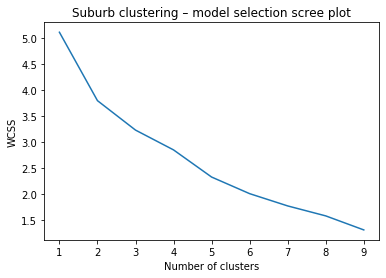

In [37]:
# Initialize total within sum of squares error: wss
wss = []

# Look over 1 to 10 possible clusters
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 2)
    kmeans.fit(sydvenues_forclustering)
    wss.append(kmeans.inertia_)

# Produce a scree plot
plt.plot(range(1, 10), wss)
plt.title('Suburb clustering – model selection scree plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The prominent elbow point occurs at 2 centres. However, there is also a change in gradient at 3 centres. The scree plot, like k-means itself, is exploratory and the elbow point is not a strict rule – rather the whole plot can help to guide this decision. Weighing up considerations of potential usefulness, 3 clusters will possibly be more informative for analysis. So now the k-means can commence with '3' given as the argument for number of centres.

**Running k-means algorithm, examining clusters and mapping cluster membership**

In [39]:
# Inspect where the elbow point occurs in scree plot. From the plot produced it looks like 3 is a reasonable option.

# Setting number of clusters
kclusters = 3

# Run k-means clustering
km_out = KMeans(n_clusters = kclusters, random_state=1).fit(sydvenues_forclustering)

# Check cluster labels generated for each row in the dataframe
print(len(km_out.labels_))
km_out.labels_[0:31]

32


array([0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 2, 0], dtype=int32)

Now the cluster membership labels can be added back to the suburbs and the Foursquare most common venues data for added context.

In [42]:
sydsub_fsvenues_sorted.insert(0, 'Cluster', km_out.labels_)
sydsub_fsvenues_sorted

,Cluster,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Alexandria,Café,Pizza Place,Australian Restaurant,Lebanese Restaurant,Flea Market
1,0,Annandale,Café,Grocery Store,Fried Chicken Joint,Pub,Bar
2,0,Camperdown,Café,Gastropub,Pub,Korean Restaurant,Sports Bar
3,0,Chippendale,Café,Bar,Coffee Shop,Pub,Hotel
4,2,Darling Point,Harbor / Marina,Park,Convenience Store,Boat or Ferry,Café
5,0,Darlinghurst,Café,Japanese Restaurant,Italian Restaurant,Bar,Pub
6,0,Darlington,Café,Pub,Performing Arts Venue,Italian Restaurant,Thai Restaurant
7,1,Eastlakes,Jewelry Store,Golf Course,Thai Restaurant,Yoga Studio,Flea Market
8,2,Edgecliff,Café,Supermarket,Tennis Stadium,Train Station,Intersection
9,0,Elizabeth Bay,Café,Italian Restaurant,Australian Restaurant,Park,Hotel


It's appropriate now to make use of summary data from both of the data sources for added context – the most common venues (from Foursquare) and now also the number of small bars in each suburb (from Data.NSW). 

This is a critical piece of information to include regarding the status quo of small bars in these suburbs since it's the current count of active small bar licences. Let's add that to this dataframe now.

In [43]:
# Extraction and manipulation from Data.NSW dataset for small bar licence counts for suburbs of interest

lictype_counts = suburbs_prem_types.groupby(["Suburb", "Licence Type"]).size().reset_index(name="Count")
smallbar_counts = lictype_counts.loc[lictype_counts['Licence Type']=="Liquor - small bar licence"]
sub_smallbar_counts_lc = smallbar_counts['Suburb'].str.lower()
sub_smallbar_counts_c = sub_smallbar_counts_lc.str.title()
sbars = smallbar_counts.drop(columns=['Suburb'])
sbars['Suburb'] = sub_smallbar_counts_c
sbars = sbars[['Suburb', 'Licence Type', 'Count']]
sbars.columns=['Suburb', 'Licence Type', 'Number of Small Bars']
sbars_final = sbars.drop(columns=['Licence Type'])
sbars_final

,Suburb,Number of Small Bars
5,Alexandria,1
11,Annandale,1
22,Chippendale,3
32,Darlinghurst,8
46,Enmore,3
61,Glebe,2
71,Mascot,1
76,Newtown,8
88,Potts Point,1
94,Redfern,3


In [48]:
# Merging and cleaning the updated summary dataframe
sydsub_venues_context = sydsub_fsvenues_sorted.merge(sbars_final, on='Suburb', how='left')
sydsub_venues_context['Number of Small Bars'] = sydsub_venues_context['Number of Small Bars'].fillna(0)
sydsub_venues_context['Number of Small Bars'] = sydsub_venues_context["Number of Small Bars"].astype(int)

sydsub_venues_context.head()

,Cluster,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Number of Small Bars
0,0,Alexandria,Café,Pizza Place,Australian Restaurant,Lebanese Restaurant,Flea Market,1
1,0,Annandale,Café,Grocery Store,Fried Chicken Joint,Pub,Bar,1
2,0,Camperdown,Café,Gastropub,Pub,Korean Restaurant,Sports Bar,0
3,0,Chippendale,Café,Bar,Coffee Shop,Pub,Hotel,3
4,2,Darling Point,Harbor / Marina,Park,Convenience Store,Boat or Ferry,Café,0


**What are the characteristics of the clusters produced?**

Broadly, the '0' cluster includes suburbs which tend towards having more venues focused on nightlife activity and the '2' cluster includes suburbs which tend towards featuring more venues focused on daytime activities. The '1' cluster includes the suburb of Eastlakes only. From inspection it seems it also tends towards daytime activity venues but within this the specific venue types appear to be substantially different from the venues present in the '2' cluster. However a limitation of the data is that Foursquare returned only 2 venues and the licence list features only 4 sites for Eastlakes, respectively.

There is an overwhelmingly popular venue in the Foursquare data across many of the suburbs queried – cafes. Looking beyond the 1st most common venues where cafes dominate, the '0' cluster suburbs tend to feature bars and pubs in the their top five venue types. The two suburbs with the most small bar licences, Newtown and Darlinghurst (8 each), are '0' cluster members. Whereas the '2' cluster suburbs top five venue types features parks, transport infrastructure, convenience/grocery stores and bakeries.

The total small bar licences in the cluster '0' suburbs is 35 while the total small bar licences in the cluster '2' suburbs is 0.

In [45]:
clust_0 = sydsub_venues_context.loc[sydsub_venues_context.Cluster==0]
clust_2 = sydsub_venues_context.loc[sydsub_venues_context.Cluster==2]
print('Cluster 0 total small bars: ' + str(sum(clust_0['Number of Small Bars'])))
print('Cluster 2 total small bars: ' + str(sum(clust_2['Number of Small Bars'])))

Cluster 0 total small bars: 35
Cluster 2 total small bars: 0


Therefore cluster '0' reflects the night time economy engaged inner Sydney suburbs at the precipice of the CBD. It is where there is a demonstrated interest for small bar venues – and in some of these suburbs, possibly even a crowded market. 

Meanwhile cluster '1' tends towards more a suburban environment with staples retail and amenities for active lifestyles, families and daytime activity. However, further exploration could point to particular cluster '1' suburbs that may be good candidates for future small bar sites. There could be consideration of, for example, their proximity to cluster '0' suburbs' active night time economy centres. Let's take a look at the clustered suburbs on a map.

**Mapping the cluster membership**

We've got the features nearly ready for a map visualisation of the cluster membership – however, we first need to add the suburb coordinates data back into the dataframe in order to plot the points.

In [46]:
sydclusters_map = revised_syd_suburbs_gcoded
sydclusters_map = sydclusters_map.join(sydsub_venues_context.set_index('Suburb'), on='Suburb')
sydclusters_map.head()

,Suburb,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Number of Small Bars
0,Chippendale,-33.886329,151.199821,0,Café,Bar,Coffee Shop,Pub,Hotel,3
1,Darlington,-33.890862,151.193216,0,Café,Pub,Performing Arts Venue,Italian Restaurant,Thai Restaurant,0
2,Darlinghurst,-33.878338,151.219225,0,Café,Japanese Restaurant,Italian Restaurant,Bar,Pub,8
3,Surry Hills,-33.884512,151.210030,0,Café,Pub,Coffee Shop,Japanese Restaurant,Vietnamese Restaurant,3
4,Elizabeth Bay,-33.871691,151.228287,0,Café,Italian Restaurant,Australian Restaurant,Park,Hotel,0


We're now ready to map the suburbs with an aesthetic for cluster membership.

In [47]:
# Create basemap
mapped_clusters = folium.Map(location=[sur_lat, sur_long], tiles='Stamen Toner', zoom_start=12)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster, sbars in zip(sydclusters_map['Latitude'], sydclusters_map['Longitude'], sydclusters_map['Suburb'], sydclusters_map['Cluster'], sydclusters_map['Number of Small Bars']):
    label = folium.Popup(str(poi) + ', Cluster: ' + str(cluster) + ', Small Bars: ' + str(sbars), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mapped_clusters)
       
mapped_clusters

***Map: Suburb k-means cluster membership***

Static image preview of output:
![](https://eugeneward.com.au/study/images/coursera_capstone/capstone_map3.jpg)

The cluster '0' (red markers) member suburbs - i.e. the 'night life' suburbs – radiate outward from the Sydney CBD (at the north of the focus area). The cluster '1' suburbs (green markers) are then at the edges of the '0' cluster suburbs. However there is an exception to this pattern, where Sydenham and St Peters ('1' cluster members) are surrounded by '0' cluster suburbs to their north, east and south.

Though all of the licence type frequency data is underlying in the k-means clustering, the only feature we have explicitly drilled down to for commentary from the Data.NSW premises list dataset so far has been small bars. Let's supplement the map above with a visualisation of the total hospitality and liquor sales activity for the suburbs of interest by mapping frequency counts for all licence types to the radius size of the map markers.

In [104]:
# Getting total licences in new dataframe

lic_counts = suburbs_prem_types['Suburb'].value_counts()
lic_counts_df = lic_counts.to_frame()
lic_counts_df.rename(columns={'Suburb':'Number of Licences'}, inplace=True)
lic_counts_df.index.name = 'Suburb'
lic_counts_df.reset_index(inplace = True)
lic_counts_df.head()

,Suburb,Number of Licences
0,SURRY HILLS,231
1,DARLINGHURST,178
2,NEWTOWN,132
3,POTTS POINT,110
4,ALEXANDRIA,86


This is the aggregate total across all licence types, which, as noted in the IDA, are:

In [86]:
catlist

['Liquor - on-premises licence',
 'Liquor - packaged liquor licence',
 'Liquor - hotel licence',
 'Liquor - producer wholesaler licence',
 'Liquor - limited licence',
 'Liquor - club licence',
 'Liquor - small bar licence',
 'Liquor - pop-up licence']

In [72]:
# Cleaning suburb names 

lic_counts_df_lc = lic_counts_df['Suburb'].str.lower()
lic_counts_df_c = lic_counts_df['Suburb'].str.title()
lic_totals = lic_counts_df.drop(columns=['Suburb'])
lic_totals['Suburb'] = lic_counts_df_c
lic_totals = lic_totals[['Suburb','Number of Licences']]

# Joining to geocoded suburb dataframe as new dataframe
sydlic_map = revised_syd_suburbs_gcoded
sydlic_map = sydlic_map.join(lic_totals.set_index('Suburb'), on='Suburb')
sydlic_map.head()

,Suburb,Latitude,Longitude,Number of Licences
0,Chippendale,-33.886329,151.199821,67
1,Darlington,-33.890862,151.193216,5
2,Darlinghurst,-33.878338,151.219225,178
3,Surry Hills,-33.884512,151.210030,231
4,Elizabeth Bay,-33.871691,151.228287,10


In [87]:
# Creating map
## Setting new centre point to suit zoom
wloo = syd_suburbs_gcoded.loc[syd_suburbs_gcoded['Suburb']=='Waterloo']
wloo_lat = float(wloo['Latitude'])
wloo_long = float(wloo['Longitude'])

## Setting folium basemap
sub_licences_syd = folium.Map(location=[wloo_lat, wloo_long], tiles='Stamen Toner', zoom_start=13)

## Adding suburb markers to map
for lat, lng, label, total in zip(sydlic_map['Latitude'], sydlic_map['Longitude'], sydlic_map['Suburb'], sydlic_map['Number of Licences']):
    label = folium.Popup(label + ', total licences: ' + str(total), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=total/5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sub_licences_syd)  
    
sub_licences_syd

***Map: Aggregate liquor licences for suburbs***

Static image preview of output:
![](https://eugeneward.com.au/study/images/coursera_capstone/capstone_map4.jpg)

The centrally located Surry Hills and Darlinghurst have the highest level of hospitality and liquor retail activity. However there isn't a linear tapering down of activity outward from these suburbs – there are 'satellite' centres of liquor licence-related commercial activity (the third and fourth ranked suburbs, each with over 100 licences): Newtown and Potts Point.

Let's add to this same map with a marker to indicate presence of 1 or more small bars.

In [155]:
# Preparing data for layer
sydlic_map_layer2 = revised_syd_suburbs_gcoded
sydlic_map_layer2 = sydlic_map_layer2.join(sbars_final.set_index('Suburb'), on='Suburb')
sydlic_map_layer2 = sydlic_map_layer2.dropna()
sydlic_map_layer2['Number of Small Bars'] = sydlic_map_layer2['Number of Small Bars'].astype(int)

# Adding suburb markers to map
for lat, lng, label, smbars in zip(sydlic_map_layer2['Latitude'], sydlic_map_layer2['Longitude'], sydlic_map_layer2['Suburb'], sydlic_map_layer2['Number of Small Bars']):
    label = folium.Popup(label + ', small bars: ' + str(smbars), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=smbars,
        popup=label,
        color='red',
        parse_html=False).add_to(sub_licences_syd)  
    
sub_licences_syd

***Map: Aggregate liquor licences for suburbs with number of small bars***

Static image preview of output:
![](https://eugeneward.com.au/study/images/coursera_capstone/capstone_map5.jpg)

Interestingly, despite its top position for total licences, Surry Hills is not the top suburb for small bars. Instead this position is held by Newtown and Darlinghurst, each with 8 small bars. The highest proportional score for small bar presence relative to total licences is Enmore, where small bars make up 3 licences out of a total 28 active liquor licences. This visualisation also shows that small bars tend to be located to the west of the latitude of the Sydney CBD and Surry Hills. Past Potts Point, there are zero small bars in the suburbs of interest to the east (Rushcutters Bay, Elizabeth Bay, Edgecliff, Darling Point, Point Piper and Woollahra) or those directly south past Redfern (Waterloo, Zetland, Kensington, Rosebery and Eastlakes).

### 2.4: Liveable Sydney Study data

As mentioned earlier, the Liveable Sydney Study 2019 was commissioned by Domain Group and involved analyses by consultants Tract and Deloitte. It scored all of Sydney's suburbs on 19 liveability indicators. A selection of some of these indicators are examined here for the suburbs of interest in order to supplement this project's research regarding the decision on best candidate suburbs for future small bar locations. The data was read in earlier from the a geojson into a geopandas dataframe.

In [106]:
type(domainlive)

geopandas.geodataframe.GeoDataFrame

For this project we will not be using the suburb geometry in this data so we can drop the feature and convert the data to a stanard pandas dataframe.

In [108]:
domainlive_data = domainlive.drop(columns=['geometry'])
domainlive_data = pd.DataFrame(domainlive_data)
print(type(domainlive_data))
domainlive_data.head()

<class 'pandas.core.frame.DataFrame'>


,airport_noise_score,bucket_rank,bus_score,cafe_tot_score,coast_beach_score,congestion_score,crime_score,culture_score,educ_prim_score,educ_sec_score,...,slug,state,suburb,topo_var_score,total_rank,train_score,tram_score,tree_cover_score,views_score,walkability_score
0,1,4,2,5,4,1,1,5,5,5,...,newtown-nsw-2042,NSW,Newtown,3,170,5,0,1,4,5
1,1,4,4,5,4,1,1,5,3,4,...,enmore-nsw-2042,NSW,Enmore,3,263,4,0,1,4,5
2,1,5,2,5,4,1,2,5,5,5,...,erskineville-nsw-2043,NSW,Erskineville,1,196,5,0,1,4,5
3,1,12,3,5,4,1,1,5,4,3,...,st-peters-nsw-2044,NSW,St Peters,2,315,4,0,1,3,4
4,1,8,4,4,4,1,1,5,3,5,...,sydenham-nsw-2044,NSW,Sydenham,1,298,5,0,1,3,5


The scores that we are interested in from this dataset are 'bus', 'train' 'walkability' and 'culture.' The total rank may also be of interest – since it is the aspect prominently featured on Domain's content pages and may have an impact on future suburb popularity (not only for property purchasers but it may also be an index that tourists look at when deciding to choose somwhere to go for a drink).

In [116]:
# Wrangling for scores of interest

lss_scores = domainlive_data[['bus_score','culture_score','suburb','total_rank','train_score','walkability_score']]
lss_renamecols_ls = ['Bus Score','Culture Score','Suburb','Total Rank','Train Score','Walkability Score']
lss_scores.columns = lss_renamecols_ls
lss_scores_ordered = lss_scores[['Suburb','Total Rank','Culture Score','Train Score','Bus Score','Walkability Score']]
lss_scores_ordered

,Suburb,Total Rank,Culture Score,Train Score,Bus Score,Walkability Score
0,Newtown,170,5,5,2,5
1,Enmore,263,5,4,4,5
2,Erskineville,196,5,5,2,5
3,St Peters,315,5,4,3,4
4,Sydenham,298,5,5,4,5
...,...,...,...,...,...,...
564,Blacktown,349,3,4,3,4
565,Harris Park,236,5,5,3,5
566,Parramatta,80,5,5,5,5
567,North Rocks,271,4,2,4,2


In [127]:
# Merging with the geocoded dataframe of the suburbs of interest

soi_lss = revised_syd_suburbs_gcoded
soi_lss = soi_lss.join(lss_scores_ordered.set_index('Suburb'), on='Suburb')
soi_lss = soi_lss.dropna()
soi_lss.head()

,Suburb,Latitude,Longitude,Total Rank,Culture Score,Train Score,Bus Score,Walkability Score
0,Chippendale,-33.886329,151.199821,254,5,4,2,5
1,Darlington,-33.890862,151.193216,220,5,5,1,5
2,Darlinghurst,-33.878338,151.219225,35,5,4,5,5
3,Surry Hills,-33.884512,151.210030,41,5,5,4,5
4,Elizabeth Bay,-33.871691,151.228287,15,5,4,5,5


Let's calculate a simple summed aggregate score of the liveability indicators of interest for the suburbs and add that to the dataframe.

In [144]:
summing_col_ls = ['Culture Score','Train Score','Bus Score','Walkability Score']
soi_lss['Summed Score'] = soi_lss[summing_col_ls].sum(axis=1)
soi_lss_sorted = soi_lss.sort_values(by='Summed Score', ascending=False)
soi_lss_sorted.head()

,Suburb,Latitude,Longitude,Total Rank,Culture Score,Train Score,Bus Score,Walkability Score,Summed Score
19,Edgecliff,-33.879769,151.236112,10,5,5,5,5,20
18,Darling Point,-33.873072,151.237638,7,5,4,5,5,19
2,Darlinghurst,-33.878338,151.219225,35,5,4,5,5,19
3,Surry Hills,-33.884512,151.210030,41,5,5,4,5,19
4,Elizabeth Bay,-33.871691,151.228287,15,5,4,5,5,19


Let's take a look at summed LSS scores vs. number of small bars presently operating.

In [148]:
lss_and_sbars = soi_lss_sorted
lss_and_sbars = lss_and_sbars.join(sbars_final.set_index('Suburb'), on='Suburb')
lss_and_sbars = lss_and_sbars.fillna(0)
lss_and_sbars['Number of Small Bars'] = lss_and_sbars['Number of Small Bars'].astype(int)
lss_and_sbars = lss_and_sbars.drop(columns=['Culture Score','Train Score','Bus Score','Walkability Score'])
print('Mean LSS summed score: ' + str(mean(lss_and_sbars['Summed Score'])))
lss_and_sbars

Mean LSS summed score: 17.09375


,Suburb,Latitude,Longitude,Total Rank,Summed Score,Number of Small Bars
19,Edgecliff,-33.879769,151.236112,10,20,0
18,Darling Point,-33.873072,151.237638,7,19,0
2,Darlinghurst,-33.878338,151.219225,35,19,8
3,Surry Hills,-33.884512,151.210030,41,19,3
4,Elizabeth Bay,-33.871691,151.228287,15,19,0
5,Potts Point,-33.867080,151.225997,40,19,1
29,Sydenham,-33.914743,151.166107,298,19,0
7,Woolloomooloo,-33.871876,151.219222,25,19,1
10,Redfern,-33.893104,151.204029,108,19,3
8,Alexandria,-33.909157,151.192128,267,18,1


Darlinghurst, one of the current top small bar locations, scores well on these indicators while Newtown, the other top suburb for small bars, has an average score. Of interest are the suburbs which scored above average and presently have zero small bars. For added context we'll also join the suburbs' cluster labels from earlier to inspect whether they're 'night time economy' cluster members.

In [153]:
lss_and_sbars_opp = lss_and_sbars.loc[(lss_and_sbars['Number of Small Bars']==0) & (lss_and_sbars['Summed Score']>17)]
cluster_labs = sydclusters_map[['Suburb', 'Cluster']]
sbars_opp = lss_and_sbars_opp
sbars_opp = sbars_opp.join(cluster_labs.set_index('Suburb'), on='Suburb')
sbars_opp

,Suburb,Latitude,Longitude,Total Rank,Summed Score,Number of Small Bars,Cluster
19,Edgecliff,-33.879769,151.236112,10,20,0,2
18,Darling Point,-33.873072,151.237638,7,19,0,2
4,Elizabeth Bay,-33.871691,151.228287,15,19,0,0
29,Sydenham,-33.914743,151.166107,298,19,0,2
11,Waterloo,-33.900276,151.207314,148,18,0,0
12,Zetland,-33.907662,151.208218,294,18,0,0
21,Kensington,-33.911719,151.219506,132,18,0,0


---

## Section 3: Evaluation informing report recommendations

### 3.1: Evaluating the two types of opportunity suburbs

### 'Untapped neighbours to night time economy centres'

This type of opportunity suburb for small bars draws on a common driver for commercial location decisions: observing existing hotspots for a particular market and joining them in direct competition, or alternatively, as this project recommends, observing the hotspot locations and then pushing at the edges of these market centres. The idea being that you establish the business ahead of the next hotspot for first mover advantage.

In this analysis, it was observed that many of the suburbs of interest support nightlife and are well-resourced when it comes to the broader bars and hotels industry. From review of the k-means cluster analysis results, this was what seemed to be a primary characteristic that emerged in the large '0' cluster of suburbs. However, as observed in the map visualisation 'Aggregate liquor licences for suburbs with number of small bars,' there wasn't a direct correlation with high numbers of liquor licences of all kinds and the presence of currently operating small bars. Newtown, Darlinghurst and Enmore demonstrate that there are 'CBD precipice' suburb characteristics presently attracting small bar operators, which may potentially include a civic structure where commercial centres co-mingle with but do not overwhelm residential areas. A small bar should be a short walk for locals, like the night-time equivalent of a cafe – it is not necessarily something they will venture to the CBD for.


### 'New directions'

The second type of opportunity suburb is also guided by the aim to forecast future hotpots in this market. However, rather than beginning with the criteria of proximity to an active centre, this category of recommended suburbs goes further afield and is instead based on exceptional scoring in suitability evaluation. These are suburbs not necessarily abutting the night time economy centres, but which score above average in the relevant liveability indicators, ranked highly overall in the LSS and, importantly, are also members of the '0' cluster, indicating similarity to active night time economy suburbs and thefore potentially an environment and context that would suit small bars.


### 3.2: Recommended suburbs for future small bar locations
### Recommended suburbs for 'untapped neighbours'

**Priority recommended suburb**:

***Paddington***

Cluster membership: '0'

Current number of small bars: 0

LSS summed score on liveabiliy indicators of interest: 17

LSS suburb total rank: 16

Neighbouring night time economy centre: Darlinghurst

---

**Other recommended suburbs**: 

***Erskineville***

LSS summed score on liveabiliy indicators of interest: 17

Cluster membership: '0'

Current number of small bars: 0

LSS suburb total rank: 196

Neighbouring night time economy centre: Newtown


***Camperdown***

LSS summed score on liveabiliy indicators of interest: 17

Cluster membership: '0'

Current number of small bars: 0

LSS suburb total rank: 182

Neighbouring night time economy centre: Newtown

---

### Recommended suburbs for 'new directions'

**Priority recommended suburb:** 

***Elizabeth Bay***

LSS summed score on liveabiliy indicators of interest: 19

Cluster membership: '0'

Current number of small bars: 0

LSS suburb total rank: 15

---

**Other recommended suburbs:**

***Kensington***

LSS summed score on liveabiliy indicators of interest: 18

Cluster membership: '0'

Current number of small bars: 0

LSS suburb total rank: 132


***Waterloo***

LSS summed score on liveabiliy indicators of interest: 18

Cluster membership: '0'

Current number of small bars: 0

LSS suburb total rank: 148
